In [ ]:
import numpy as np, torch, json, time, os, igl
from Ctubes.geometry_utils import regular_polygon
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_exact, load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 17: Tangency to Minimal Surface

## #1: Pinned Ridge (Reference)

In [3]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig17_min_surf_winfty")

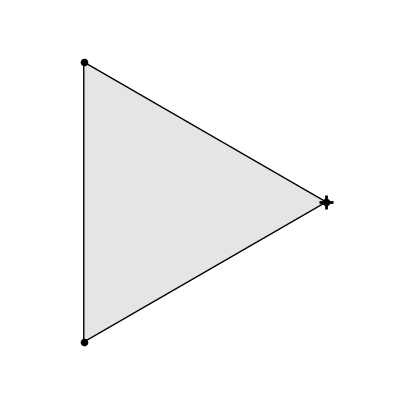

In [4]:
# Generatrix: regular N-gon
N = 3
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

# Translate cross-section s.t. the first vertex is at the origin
generatrix_2d = generatrix_2d - generatrix_2d[0]

fig, ax = plot_generatrix(generatrix_2d)

In [5]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig17_min_surf/directrix_Q_high_res.obj"))
K = cps_ref.shape[0]
M = K

In [6]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

tube = CTube(directrix, generatrix)

In [7]:
# Load surface from obj file
obj_file = os.path.join(paths["data"], f"fig17_min_surf/min_surf.obj")
V_surf, F_surf = igl.read_triangle_mesh(obj_file)

V_surf = torch.tensor(V_surf, dtype=TORCH_DTYPE)
F_surf = torch.tensor(F_surf, dtype=torch.int64)

directrix_target_surf_boundary = tube.directrix.clone()

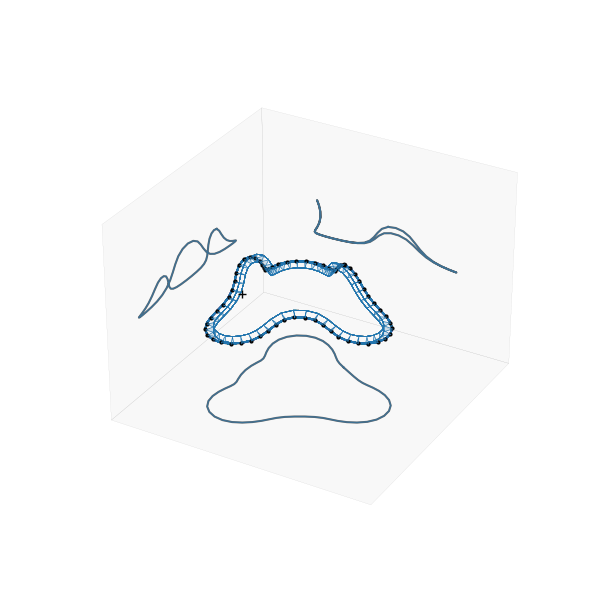

In [8]:
fig, ax = tube.plot_3d()

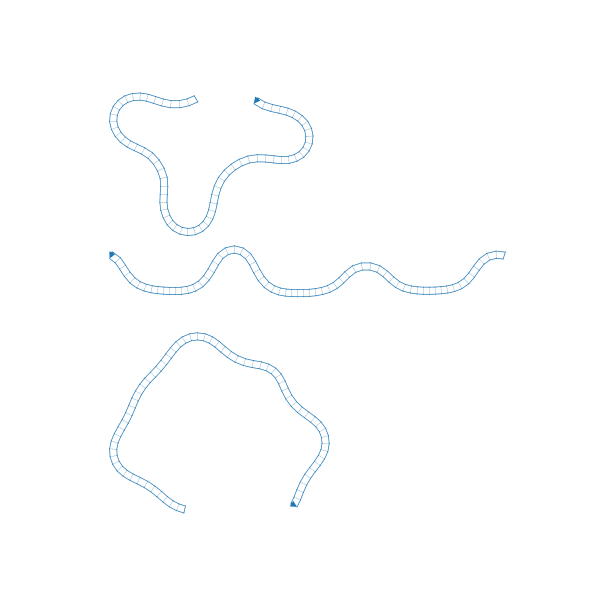

In [9]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [10]:
target_surface = {
    'vertices': V_surf,
    'faces': F_surf
}

In [11]:
# Set up optimization problem

opt_weights = {
    'join_ends': 1e1 / generatrix.aabb_diagonal_length() ** 2,
    'constrain_tube_ridges_to_surface': 1e0 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_exact(N),
    'target_surface': target_surface,
    'constrained_tube_ridges': [0, 1]
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(True)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [12]:
opt_prob.compute_objective(print_to_console=True)

join_ends                               : 0.0000177250
constrain_tube_ridges_to_surface        : 14.4229283409
smooth_plane_normal_diffs               : 0.0119832748
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(14.4349)

In [13]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [14]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44349D+01    |proj g|=  1.05366D+01

At iterate    1    f=  1.19717D+01    |proj g|=  2.01636D-01

At iterate    2    f=  1.19703D+01    |proj g|=  6.17260D-02


 This problem is unconstrained.



At iterate    3    f=  1.19702D+01    |proj g|=  2.41675D-03

At iterate    4    f=  1.19702D+01    |proj g|=  1.97063D-03

At iterate    5    f=  1.19702D+01    |proj g|=  1.97064D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5     19      1     0     0   1.971D-03   1.197D+01
  F =   11.970229105658705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [15]:
opt_prob.compute_objective(print_to_console=True)

join_ends                               : 0.0000176137
constrain_tube_ridges_to_surface        : 11.9582282172
smooth_plane_normal_diffs               : 0.0119832748
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(11.9702)

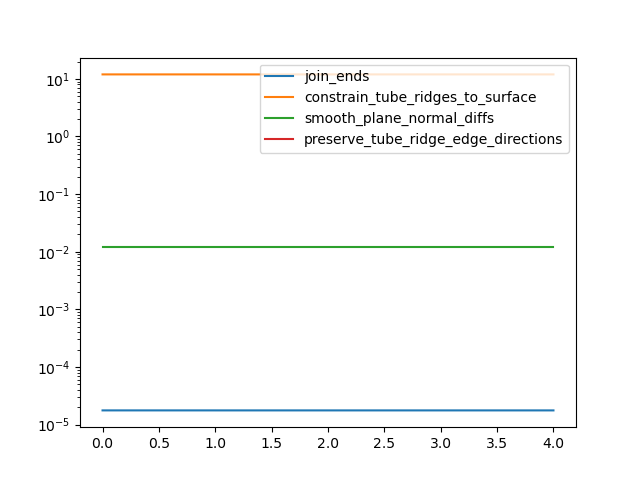

In [16]:
fig, ax = opt_prob.plot_objective_history()

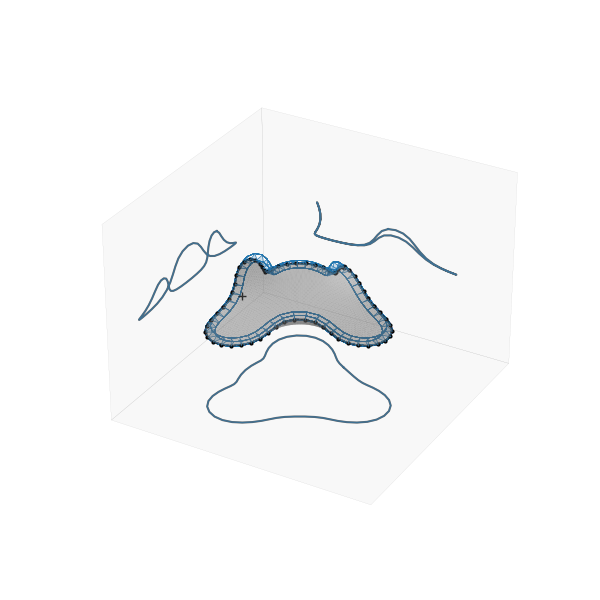

In [17]:
fig, ax = opt_prob.plot_3d()

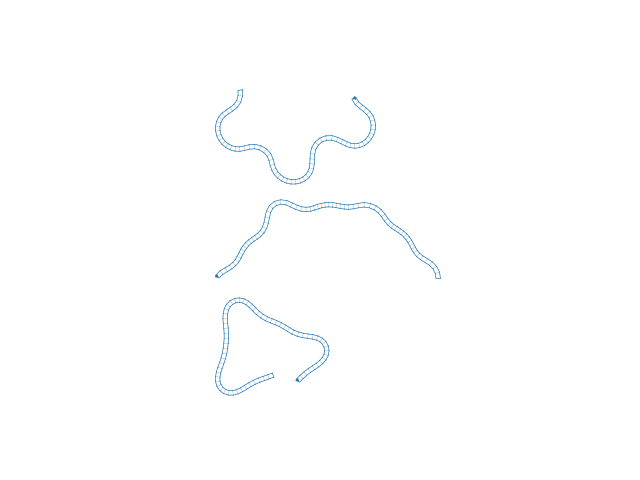

In [18]:
fig, ax = opt_prob.plot_unrolled_strips()

### Generate target fitting data for rendering 

In [ ]:
# Compute the distance of the constrained ridges from the target surface
from Ctubes.geometry_utils import point_mesh_squared_distance
ctube_vertices = opt_prob.tube_network.tubes[0].ctube_vertices
V_surf = opt_prob.objective_args['target_surface']['vertices']
F_surf = opt_prob.objective_args['target_surface']['faces']

constr_ridge_indices = [0, 1]
n_constr_ridges = len(constr_ridge_indices)
constrained_vertices = ctube_vertices[:, constr_ridge_indices]
pts_surf_squared_dist = torch.zeros((M, n_constr_ridges))
for i in range(M):
    for j in range(n_constr_ridges):
        pts_surf_squared_dist[i, j] += point_mesh_squared_distance(constrained_vertices[i, j].reshape(-1, 3), V_surf, F_surf)

# Format data, save json
data = {}
for j, ridge_i in enumerate(constr_ridge_indices):
    data[f"points_ridge_{ridge_i}"] = constrained_vertices[:, j].detach().numpy().tolist()
    data[f"surface_deviation_ridge_{ridge_i}"] = pts_surf_squared_dist[:, j].detach().numpy().tolist()
json_data = {}
json_data['surface_deviation'] = data

In [20]:
# Save the data as json
file_path = os.path.join(paths["output_data"], "{}_target_deviation.json".format(paths["name"]))
with open(file_path, 'w') as f:
    json.dump(json_data, f, indent=4)

## #2: C-Tube Ridge Attraction to Surface Boundary

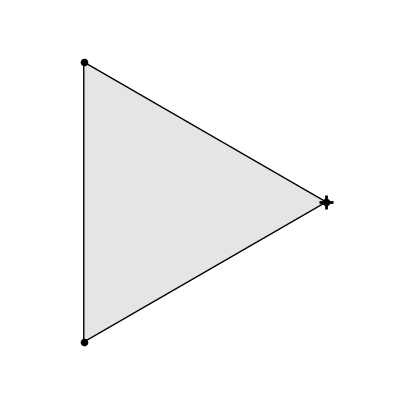

In [21]:
# Generatrix: regular N-gon
N = 3
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

# Translate cross-section s.t. the first vertex is at the origin
generatrix_2d = generatrix_2d - generatrix_2d[0]

fig, ax = plot_generatrix(generatrix_2d)

In [22]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig17_min_surf/directrix_Q_low_res.obj"))
K = cps_ref.shape[0]
M = (K - 1) * 4 + 1

In [23]:
# Load surface from obj file
obj_file = os.path.join(paths["data"], f"fig17_min_surf/min_surf.obj")
V_surf, F_surf = igl.read_triangle_mesh(obj_file)

V_surf = torch.tensor(V_surf, dtype=TORCH_DTYPE)
F_surf = torch.tensor(F_surf, dtype=torch.int64)

In [24]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

tube = CTube(directrix, generatrix)

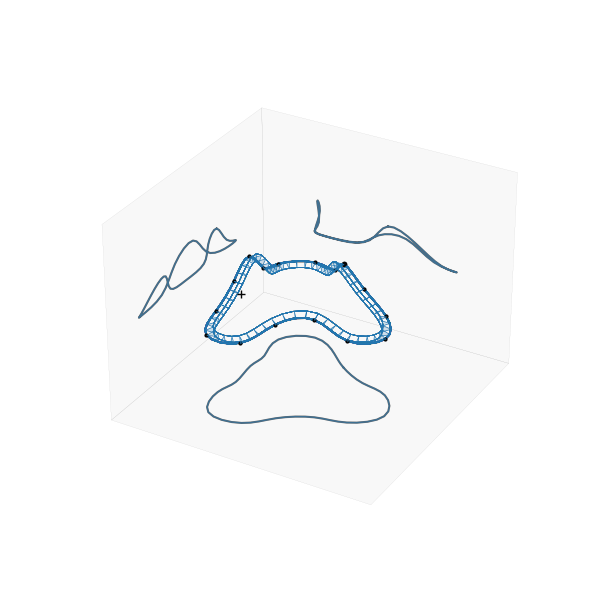

In [25]:
fig, ax = tube.plot_3d()

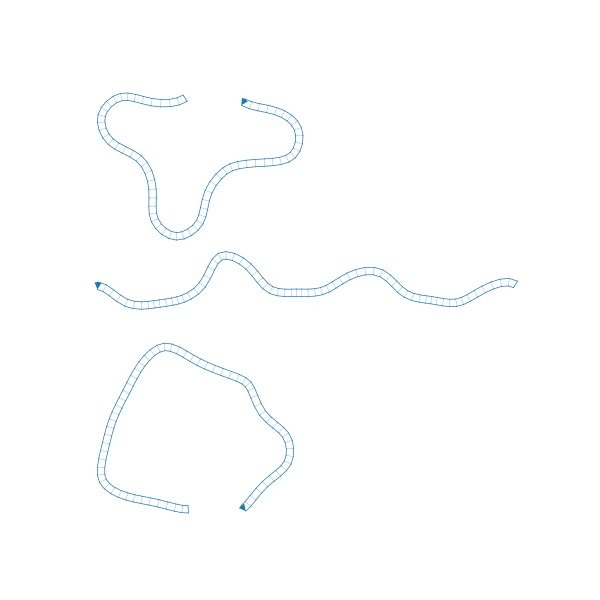

In [26]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [27]:
target_surface = {
    'vertices': V_surf,
    'faces': F_surf
}

In [28]:
w_preserve_curve = 1e3

In [ ]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': w_preserve_curve / directrix.aabb_diagonal_length() ** 2,
    'preserve_tube_ridge_edge_directions': 1e4 / directrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 1e2,
    'join_ends': 1e3 / generatrix.aabb_diagonal_length() ** 2,
    'constrain_tube_ridges_to_surface': 1e0 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_exact(N),
    'target_surface': target_surface,
    'constrained_tube_ridges': [0, 1],
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(True)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [30]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig17_min_surf_w{}".format(w_preserve_curve))

In [31]:
# Set the target directrix equal to the boundary of the target surface
opt_prob.tube_network.tubes[0].directrix_ref = directrix_target_surf_boundary

In [32]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0375676372
preserve_tube_ridge_edge_directions     : 0.0000000000
smooth_plane_normal_diffs               : 1.1705170445
join_ends                               : 0.2216662045
constrain_tube_ridges_to_surface        : 12.5779015677


tensor(14.0077)

In [33]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [34]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 500},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           49     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40077D+01    |proj g|=  2.22838D+01

At iterate    1    f=  1.34117D+01    |proj g|=  8.11269D+00


 This problem is unconstrained.



At iterate    2    f=  1.24009D+01    |proj g|=  1.24988D+01

At iterate    3    f=  9.69557D+00    |proj g|=  2.14897D+01

At iterate    4    f=  8.07180D+00    |proj g|=  1.33874D+01

At iterate    5    f=  7.38647D+00    |proj g|=  3.81272D+00

At iterate    6    f=  7.18819D+00    |proj g|=  5.57599D+00

At iterate    7    f=  7.03671D+00    |proj g|=  8.00756D+00

At iterate    8    f=  6.81488D+00    |proj g|=  5.91607D+00

At iterate    9    f=  6.64875D+00    |proj g|=  2.05241D+00

At iterate   10    f=  6.52974D+00    |proj g|=  5.26675D+00

At iterate   11    f=  6.43488D+00    |proj g|=  8.24126D+00

At iterate   12    f=  6.15713D+00    |proj g|=  1.35019D+01

At iterate   13    f=  5.85882D+00    |proj g|=  1.25809D+01

At iterate   14    f=  5.79053D+00    |proj g|=  1.41373D+01

At iterate   15    f=  5.29467D+00    |proj g|=  4.40400D+00

At iterate   16    f=  5.18660D+00    |proj g|=  3.32287D+00

At iterate   17    f=  5.15451D+00    |proj g|=  3.81182D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  191    f=  3.00198D+00    |proj g|=  2.51956D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   49    192    305      3     0     0   2.520D-03   3.002D+00
  F =   3.0019784258332329     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [41]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 1.4234581432
preserve_tube_ridge_edge_directions     : 0.0000000000
smooth_plane_normal_diffs               : 0.4410631048
join_ends                               : 0.0004114740
constrain_tube_ridges_to_surface        : 1.1370457039


tensor(3.0020, grad_fn=<AddBackward0>)

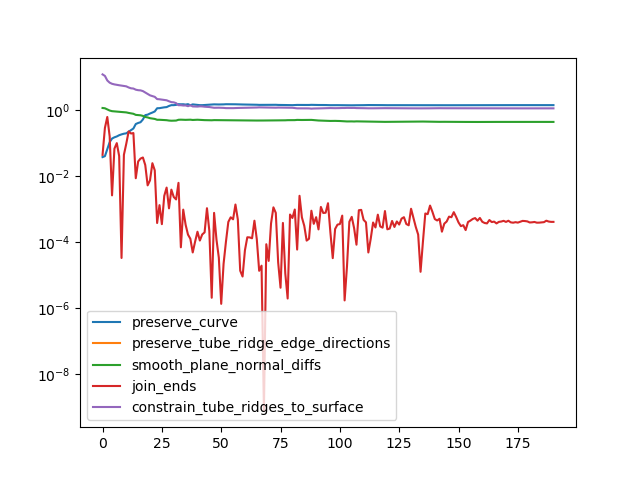

In [42]:
fig, ax = opt_prob.plot_objective_history()

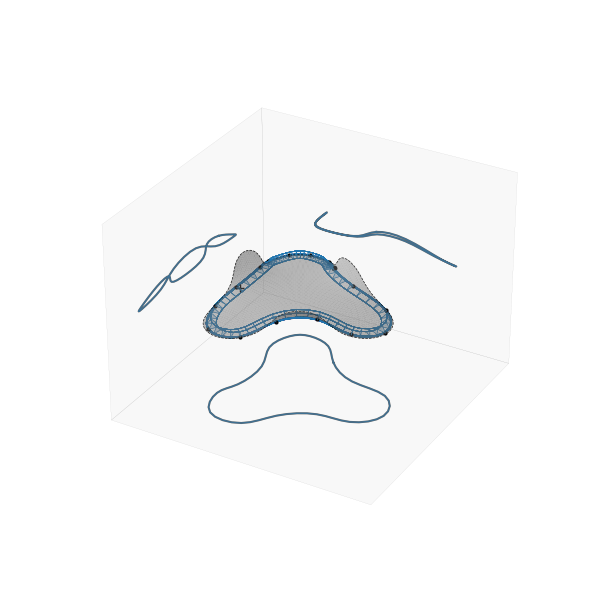

In [43]:
fig, ax = opt_prob.plot_3d()

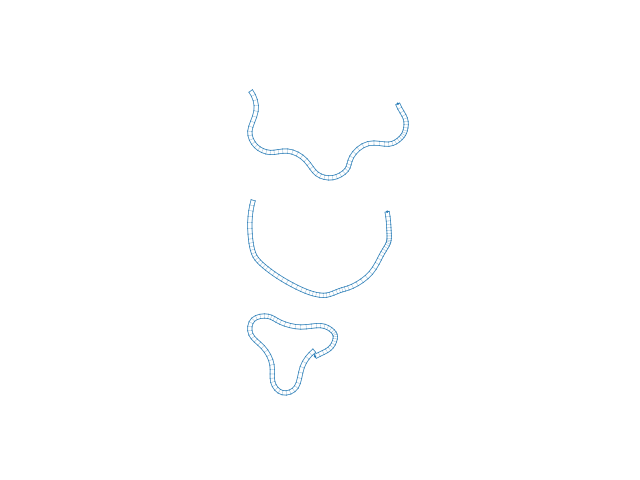

In [44]:
fig, ax = opt_prob.plot_unrolled_strips()

### Generate target fitting data for rendering 

In [ ]:
# Compute the distance of the constrained ridges from the target surface
from Ctubes.geometry_utils import point_mesh_squared_distance
ctube_vertices = opt_prob.tube_network.tubes[0].ctube_vertices
V_surf = opt_prob.objective_args['target_surface']['vertices']
F_surf = opt_prob.objective_args['target_surface']['faces']

constr_ridge_indices = [0, 1]
n_constr_ridges = len(constr_ridge_indices)
constrained_vertices = ctube_vertices[:, constr_ridge_indices]
pts_surf_squared_dist = torch.zeros((M, n_constr_ridges))
for i in range(M):
    for j in range(n_constr_ridges):
        pts_surf_squared_dist[i, j] += point_mesh_squared_distance(constrained_vertices[i, j].reshape(-1, 3), V_surf, F_surf)

# Format data, save json
data = {}
for j, ridge_i in enumerate(constr_ridge_indices):
    data[f"points_ridge_{ridge_i}"] = constrained_vertices[:, j].detach().numpy().tolist()
    data[f"surface_deviation_ridge_{ridge_i}"] = pts_surf_squared_dist[:, j].detach().numpy().tolist()
json_data = {}
json_data['surface_deviation'] = data

In [40]:
# Save the data as json
file_path = os.path.join(paths["output_data"], "{}_target_deviation.json".format(paths["name"]))
with open(file_path, 'w') as f:
    json.dump(json_data, f, indent=4)